Linear regression model - most basic
y = rate of alz
x = fips code

do a geospatial trend (why we have fips code as x)

then:
run a logistic regression model
falling, rising, stable based on fips code

steps alz:
1. make a new df with just fips code (as x), mean prevelance% (as y)
2. train 80% train, 20% test with this - since we have a lot of data
3. run a Linear regression model after that
4. requires time!
5. import statsmodels.api


or:
group by region (north, south, east, west) - 4 regions
1. on avg, around 785 counties per region
2. train on each county in the region.
3. 80% train, 20% test
then do the entire nation after

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [31]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_column", None)

In [32]:
state_map = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
    'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
    'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico',
    'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

def makeFipsData():
    df_fips = pd.read_csv("datasets/fips_codes.csv")
    df_fips = df_fips.dropna().reset_index()
    df_fips = df_fips.drop(columns="index")
    df_fips['state'] = df_fips['state'].map(state_map)
    df_fips["County"] = df_fips["name"] + ", " + df_fips['state']
    return df_fips

def cleanAlzData(fileName):
    df = pd.read_csv("datasets/" + fileName)
    df = df.drop(columns=["Unnamed: 0"])
    df_fips = makeFipsData()
    df[['Mean Prevelance%', '95% CI Low Prevelance%', '95% CI High Prevelance%']] = df['Prevalence, % (95%CI)'].str.extract(r'([\d.]+) \(([\d.]+), ([\d.]+)\)')
    df[['Mean Diagnosis Count', '95% CI Low Diagnosis Count', '95% CI High Diagnosis Count']] = df['No. (95%CI) of people with AD, in thousands'].str.extract(r'([\d.]+) \(([\d.]+), ([\d.]+)\)')
    df[['Mean Prevelance%', '95% CI Low Prevelance%', '95% CI High Prevelance%']] = df[['Mean Prevelance%', '95% CI Low Prevelance%', '95% CI High Prevelance%']].astype(float)
    df[['Mean Diagnosis Count', '95% CI Low Diagnosis Count', '95% CI High Diagnosis Count']] = df[['Mean Diagnosis Count', '95% CI Low Diagnosis Count', '95% CI High Diagnosis Count']].astype(float)
    df = pd.merge(df, df_fips, how="left", on="County")
    df.insert(1, "FIPS", df.pop("fips"))
    return df

def cleanCancerData(fileName):
    df = pd.read_csv("datasets/" + fileName, skiprows=8)
    df = df.dropna()
    df.index -= 1
    df = df[(df["Lower 95% Confidence Interval"] != "data not available") & (df["Average Annual Count"] != "3 or fewer")]
    #Must include when initializing dataframe:
    df = df.drop(columns=["Lower CI (CI*Rank)", "CI*Rank([rank note])", "Upper CI (CI*Rank)"])
    df["County"] = df["County"].str[:-3]
    return df

In [33]:
df_fips = makeFipsData()
df_fips.head(10)

,fips,name,state,County
0,1001,Autauga County,Alabama,"Autauga County, Alabama"
1,1003,Baldwin County,Alabama,"Baldwin County, Alabama"
2,1005,Barbour County,Alabama,"Barbour County, Alabama"
3,1007,Bibb County,Alabama,"Bibb County, Alabama"
4,1009,Blount County,Alabama,"Blount County, Alabama"
5,1011,Bullock County,Alabama,"Bullock County, Alabama"
6,1013,Butler County,Alabama,"Butler County, Alabama"
7,1015,Calhoun County,Alabama,"Calhoun County, Alabama"
8,1017,Chambers County,Alabama,"Chambers County, Alabama"
9,1019,Cherokee County,Alabama,"Cherokee County, Alabama"


In [34]:
df_alz = cleanAlzData("alz13081-sup-0004-table2.csv")
df_alz.head(10)

,County,FIPS,"No. of people age 65y and older, in thousands","Prevalence, % (95%CI)","No. (95%CI) of people with AD, in thousands","Age 85 years or more, %","Women, %","Black or African American, %","Hispanic, %",Mean Prevelance%,95% CI Low Prevelance%,95% CI High Prevelance%,Mean Diagnosis Count,95% CI Low Diagnosis Count,95% CI High Diagnosis Count,name,state
0,"Autauga County, Alabama",1001.0,9.1,"11.4 (10.8, 11.9)","1 (1, 1.1)",10.2,56.0,14.8,1.2,11.4,10.8,11.9,1.0,1.0,1.1,Autauga County,Alabama
1,"Baldwin County, Alabama",1003.0,49.5,"10 (9.5, 10.5)","4.9 (4.7, 5.2)",9.2,53.9,5.0,1.5,10.0,9.5,10.5,4.9,4.7,5.2,Baldwin County,Alabama
2,"Barbour County, Alabama",1005.0,5.0,"13.5 (12.9, 14.1)","0.7 (0.6, 0.7)",10.4,56.5,37.1,1.1,13.5,12.9,14.1,0.7,0.6,0.7,Barbour County,Alabama
3,"Bibb County, Alabama",1007.0,3.8,"11.3 (10.8, 11.9)","0.4 (0.4, 0.5)",10.5,55.7,13.7,1.5,11.3,10.8,11.9,0.4,0.4,0.5,Bibb County,Alabama
4,"Blount County, Alabama",1009.0,11.0,"10.1 (9.6, 10.7)","1.1 (1.1, 1.2)",10.1,54.6,1.4,2.7,10.1,9.6,10.7,1.1,1.1,1.2,Blount County,Alabama
5,"Bullock County, Alabama",1011.0,1.8,"16.7 (16, 17.4)","0.3 (0.3, 0.3)",11.8,56.2,64.5,1.8,16.7,16.0,17.4,0.3,0.3,0.3,Bullock County,Alabama
6,"Butler County, Alabama",1013.0,4.2,"14.5 (13.9, 15.1)","0.6 (0.6, 0.6)",13.9,59.1,33.9,0.7,14.5,13.9,15.1,0.6,0.6,0.6,Butler County,Alabama
7,"Calhoun County, Alabama",1015.0,21.0,"11.1 (10.6, 11.7)","2.3 (2.2, 2.5)",10.2,57.2,14.9,1.3,11.1,10.6,11.7,2.3,2.2,2.5,Calhoun County,Alabama
8,"Chambers County, Alabama",1017.0,6.8,"13 (12.4, 13.6)","0.9 (0.8, 0.9)",10.9,57.1,31.5,0.9,13.0,12.4,13.6,0.9,0.8,0.9,Chambers County,Alabama
9,"Cherokee County, Alabama",1019.0,6.4,"10.1 (9.6, 10.6)","0.6 (0.6, 0.7)",9.5,52.8,4.0,0.6,10.1,9.6,10.6,0.6,0.6,0.7,Cherokee County,Alabama


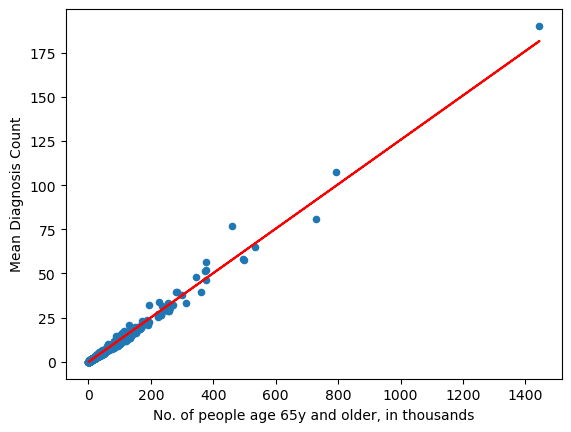

In [35]:
# scatterplot of Diagnosis Count vs Population
df_alz.plot.scatter(x="No. of people age 65y and older, in thousands", y="Mean Diagnosis Count")
slope, intercept = np.polyfit(df_alz['No. of people age 65y and older, in thousands'], df_alz['Mean Diagnosis Count'], 1)
best_fit_line = slope * df_alz['No. of people age 65y and older, in thousands'] + intercept
plt.plot(df_alz['No. of people age 65y and older, in thousands'], best_fit_line, color='red', label='Best Fit Line')
plt.show()

<Axes: xlabel='Prevelance Percentage %', ylabel='Frequency'>

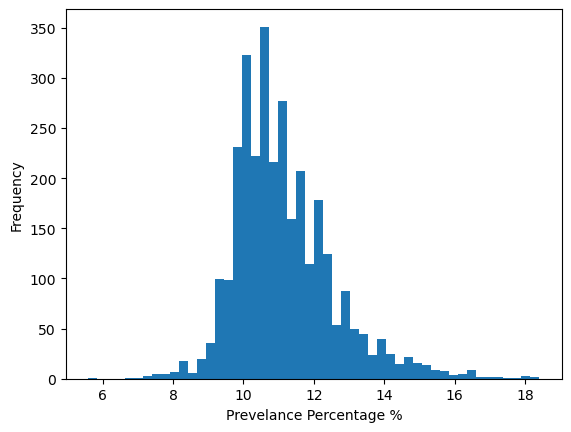

In [36]:
#histogram
df_alz["Mean Prevelance%"].plot.hist(bins=50, xlabel="Prevelance Percentage %")

<Axes: >

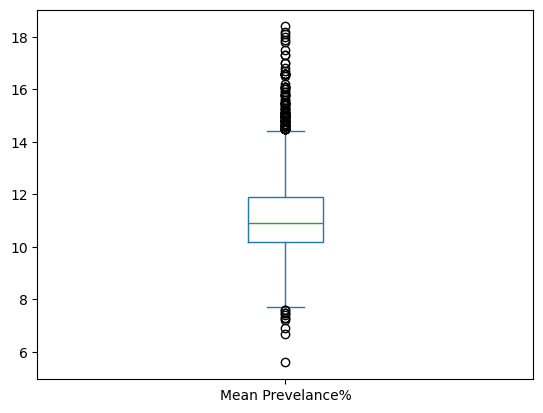

In [37]:
#Box plot
df_alz["Mean Prevelance%"].plot.box()

In [38]:
upper = df_alz["Mean Prevelance%"].quantile(0.75) + 1.5*(df_alz["Mean Prevelance%"].quantile(0.75)-df_alz["Mean Prevelance%"].quantile(0.25))
lower = df_alz["Mean Prevelance%"].quantile(0.25) - 1.5*(df_alz["Mean Prevelance%"].quantile(0.75)-df_alz["Mean Prevelance%"].quantile(0.25))

In [39]:
df_alz[df_alz["Mean Prevelance%"] > upper]

,County,FIPS,"No. of people age 65y and older, in thousands","Prevalence, % (95%CI)","No. (95%CI) of people with AD, in thousands","Age 85 years or more, %","Women, %","Black or African American, %","Hispanic, %",Mean Prevelance%,95% CI Low Prevelance%,95% CI High Prevelance%,Mean Diagnosis Count,95% CI Low Diagnosis Count,95% CI High Diagnosis Count,name,state
5,"Bullock County, Alabama",1011.0,1.8,"16.7 (16, 17.4)","0.3 (0.3, 0.3)",11.8,56.2,64.5,1.8,16.7,16.0,17.4,0.3,0.3,0.3,Bullock County,Alabama
6,"Butler County, Alabama",1013.0,4.2,"14.5 (13.9, 15.1)","0.6 (0.6, 0.6)",13.9,59.1,33.9,0.7,14.5,13.9,15.1,0.6,0.6,0.6,Butler County,Alabama
23,"Dallas County, Alabama",1047.0,7.1,"15.3 (14.6, 15.9)","1.1 (1, 1.1)",10.3,57.6,57.5,0.7,15.3,14.6,15.9,1.1,1.0,1.1,Dallas County,Alabama
31,"Greene County, Alabama",1063.0,2.0,"17.9 (17.2, 18.6)","0.3 (0.3, 0.4)",12.8,57.7,74.4,0.5,17.9,17.2,18.6,0.3,0.3,0.4,Greene County,Alabama
32,"Hale County, Alabama",1065.0,3.0,"15.4 (14.8, 16.1)","0.5 (0.4, 0.5)",11.8,56.6,50.5,0.5,15.4,14.8,16.1,0.5,0.4,0.5,Hale County,Alabama
42,"Lowndes County, Alabama",1085.0,2.0,"16.8 (16.1, 17.5)","0.3 (0.3, 0.3)",12.1,57.3,62.6,0.7,16.8,16.1,17.5,0.3,0.3,0.3,Lowndes County,Alabama
43,"Macon County, Alabama",1087.0,3.8,"17.8 (17.1, 18.5)","0.7 (0.6, 0.7)",10.9,59.0,78.5,1.0,17.8,17.1,18.5,0.7,0.6,0.7,Macon County,Alabama
45,"Marengo County, Alabama",1091.0,3.9,"14.8 (14.1, 15.4)","0.6 (0.5, 0.6)",13.0,56.2,42.7,0.9,14.8,14.1,15.4,0.6,0.5,0.6,Marengo County,Alabama
52,"Perry County, Alabama",1105.0,1.8,"16.5 (15.8, 17.2)","0.3 (0.3, 0.3)",12.2,59.8,56.3,0.8,16.5,15.8,17.2,0.3,0.3,0.3,Perry County,Alabama
59,"Sumter County, Alabama",1119.0,2.4,"17.5 (16.8, 18.2)","0.4 (0.4, 0.4)",14.7,58.0,65.5,0.6,17.5,16.8,18.2,0.4,0.4,0.4,Sumter County,Alabama


In [40]:
df_alz[df_alz["Mean Prevelance%"] < lower]

,County,FIPS,"No. of people age 65y and older, in thousands","Prevalence, % (95%CI)","No. (95%CI) of people with AD, in thousands","Age 85 years or more, %","Women, %","Black or African American, %","Hispanic, %",Mean Prevelance%,95% CI Low Prevelance%,95% CI High Prevelance%,Mean Diagnosis Count,95% CI Low Diagnosis Count,95% CI High Diagnosis Count,name,state
68,"Aleutians West Census Area, Alaska",2016.0,0.4,"6.7 (6.2, 7.1)","0 (0, 0)",4.3,39.7,2.7,5.7,6.7,6.2,7.1,0.0,0.0,0.0,Aleutians West Census Area,Alaska
70,"Bethel Census Area, Alaska",2050.0,1.5,"7.6 (7.2, 8.1)","0.1 (0.1, 0.1)",4.6,50.6,1.4,0.8,7.6,7.2,8.1,0.1,0.1,0.1,Bethel Census Area,Alaska
72,"Chugach Census Area, Alaska",NaN,0.9,"7.6 (7.2, 8.1)","0.1 (0.1, 0.1)",5.3,49.1,0.8,4.5,7.6,7.2,8.1,0.1,0.1,0.1,NaN,NaN
87,"North Slope Borough, Alaska",2185.0,0.7,"7.5 (7.1, 8)","0.1 (0.1, 0.1)",5.3,44.7,1.8,1.4,7.5,7.1,8.0,0.1,0.1,0.1,North Slope Borough,Alaska
90,"Prince of Wales-Hyder Census Area, Alaska",2198.0,1.2,"7.5 (7.1, 8)","0.1 (0.1, 0.1)",4.9,42.5,0.2,1.4,7.5,7.1,8.0,0.1,0.1,0.1,Prince of Wales-Hyder Census Area,Alaska
269,"Gilpin County, Colorado",8047.0,1.2,"6.9 (6.4, 7.4)","0.1 (0.1, 0.1)",3.2,48.2,0.6,4.1,6.9,6.4,7.4,0.1,0.1,0.1,Gilpin County,Colorado
292,"Park County, Colorado",8093.0,4.3,"7.2 (6.7, 7.6)","0.3 (0.3, 0.3)",4.0,46.5,0.6,3.4,7.2,6.7,7.6,0.3,0.3,0.3,Park County,Colorado
302,"San Miguel County, Colorado",8113.0,1.3,"7.3 (6.9, 7.8)","0.1 (0.1, 0.1)",4.9,44.3,0.6,3.3,7.3,6.9,7.8,0.1,0.1,0.1,San Miguel County,Colorado
304,"Summit County, Colorado",8117.0,4.5,"7.4 (6.9, 7.9)","0.3 (0.3, 0.4)",4.2,47.5,0.5,2.9,7.4,6.9,7.9,0.3,0.3,0.4,Summit County,Colorado
2391,"Hanson County, South Dakota",46061.0,0.6,"7.3 (6.9, 7.8)","0 (0, 0)",5.7,47.7,0.9,1.2,7.3,6.9,7.8,0.0,0.0,0.0,Hanson County,South Dakota


In [41]:
df_alz["Mean Prevelance%"].describe()

count    3142.000000
mean       11.148059
std         1.448641
min         5.600000
25%        10.200000
50%        10.900000
75%        11.900000
max        18.400000
Name: Mean Prevelance%, dtype: float64

In [42]:
upper_prevelance = df_alz["Mean Prevelance%"].quantile(0.75) + 1.5*(df_alz["Mean Prevelance%"].quantile(0.75) - df_alz["Mean Prevelance%"].quantile(0.25))
lower_prevelance = df_alz["Mean Prevelance%"].quantile(0.25) - 1.5*(df_alz["Mean Prevelance%"].quantile(0.75) - df_alz["Mean Prevelance%"].quantile(0.25))
print("upper bound: " + str(upper_prevelance.round(3)))
print("lower bound: " + str(lower_prevelance.round(3)))

upper bound: 14.45
lower bound: 7.65


In [43]:
df_alz[df_alz["Mean Prevelance%"] > upper_prevelance]

,County,FIPS,"No. of people age 65y and older, in thousands","Prevalence, % (95%CI)","No. (95%CI) of people with AD, in thousands","Age 85 years or more, %","Women, %","Black or African American, %","Hispanic, %",Mean Prevelance%,95% CI Low Prevelance%,95% CI High Prevelance%,Mean Diagnosis Count,95% CI Low Diagnosis Count,95% CI High Diagnosis Count,name,state
5,"Bullock County, Alabama",1011.0,1.8,"16.7 (16, 17.4)","0.3 (0.3, 0.3)",11.8,56.2,64.5,1.8,16.7,16.0,17.4,0.3,0.3,0.3,Bullock County,Alabama
6,"Butler County, Alabama",1013.0,4.2,"14.5 (13.9, 15.1)","0.6 (0.6, 0.6)",13.9,59.1,33.9,0.7,14.5,13.9,15.1,0.6,0.6,0.6,Butler County,Alabama
23,"Dallas County, Alabama",1047.0,7.1,"15.3 (14.6, 15.9)","1.1 (1, 1.1)",10.3,57.6,57.5,0.7,15.3,14.6,15.9,1.1,1.0,1.1,Dallas County,Alabama
31,"Greene County, Alabama",1063.0,2.0,"17.9 (17.2, 18.6)","0.3 (0.3, 0.4)",12.8,57.7,74.4,0.5,17.9,17.2,18.6,0.3,0.3,0.4,Greene County,Alabama
32,"Hale County, Alabama",1065.0,3.0,"15.4 (14.8, 16.1)","0.5 (0.4, 0.5)",11.8,56.6,50.5,0.5,15.4,14.8,16.1,0.5,0.4,0.5,Hale County,Alabama
42,"Lowndes County, Alabama",1085.0,2.0,"16.8 (16.1, 17.5)","0.3 (0.3, 0.3)",12.1,57.3,62.6,0.7,16.8,16.1,17.5,0.3,0.3,0.3,Lowndes County,Alabama
43,"Macon County, Alabama",1087.0,3.8,"17.8 (17.1, 18.5)","0.7 (0.6, 0.7)",10.9,59.0,78.5,1.0,17.8,17.1,18.5,0.7,0.6,0.7,Macon County,Alabama
45,"Marengo County, Alabama",1091.0,3.9,"14.8 (14.1, 15.4)","0.6 (0.5, 0.6)",13.0,56.2,42.7,0.9,14.8,14.1,15.4,0.6,0.5,0.6,Marengo County,Alabama
52,"Perry County, Alabama",1105.0,1.8,"16.5 (15.8, 17.2)","0.3 (0.3, 0.3)",12.2,59.8,56.3,0.8,16.5,15.8,17.2,0.3,0.3,0.3,Perry County,Alabama
59,"Sumter County, Alabama",1119.0,2.4,"17.5 (16.8, 18.2)","0.4 (0.4, 0.4)",14.7,58.0,65.5,0.6,17.5,16.8,18.2,0.4,0.4,0.4,Sumter County,Alabama


In [44]:
df_alz[df_alz["Mean Prevelance%"] < lower_prevelance]

,County,FIPS,"No. of people age 65y and older, in thousands","Prevalence, % (95%CI)","No. (95%CI) of people with AD, in thousands","Age 85 years or more, %","Women, %","Black or African American, %","Hispanic, %",Mean Prevelance%,95% CI Low Prevelance%,95% CI High Prevelance%,Mean Diagnosis Count,95% CI Low Diagnosis Count,95% CI High Diagnosis Count,name,state
68,"Aleutians West Census Area, Alaska",2016.0,0.4,"6.7 (6.2, 7.1)","0 (0, 0)",4.3,39.7,2.7,5.7,6.7,6.2,7.1,0.0,0.0,0.0,Aleutians West Census Area,Alaska
70,"Bethel Census Area, Alaska",2050.0,1.5,"7.6 (7.2, 8.1)","0.1 (0.1, 0.1)",4.6,50.6,1.4,0.8,7.6,7.2,8.1,0.1,0.1,0.1,Bethel Census Area,Alaska
72,"Chugach Census Area, Alaska",NaN,0.9,"7.6 (7.2, 8.1)","0.1 (0.1, 0.1)",5.3,49.1,0.8,4.5,7.6,7.2,8.1,0.1,0.1,0.1,NaN,NaN
87,"North Slope Borough, Alaska",2185.0,0.7,"7.5 (7.1, 8)","0.1 (0.1, 0.1)",5.3,44.7,1.8,1.4,7.5,7.1,8.0,0.1,0.1,0.1,North Slope Borough,Alaska
90,"Prince of Wales-Hyder Census Area, Alaska",2198.0,1.2,"7.5 (7.1, 8)","0.1 (0.1, 0.1)",4.9,42.5,0.2,1.4,7.5,7.1,8.0,0.1,0.1,0.1,Prince of Wales-Hyder Census Area,Alaska
269,"Gilpin County, Colorado",8047.0,1.2,"6.9 (6.4, 7.4)","0.1 (0.1, 0.1)",3.2,48.2,0.6,4.1,6.9,6.4,7.4,0.1,0.1,0.1,Gilpin County,Colorado
292,"Park County, Colorado",8093.0,4.3,"7.2 (6.7, 7.6)","0.3 (0.3, 0.3)",4.0,46.5,0.6,3.4,7.2,6.7,7.6,0.3,0.3,0.3,Park County,Colorado
302,"San Miguel County, Colorado",8113.0,1.3,"7.3 (6.9, 7.8)","0.1 (0.1, 0.1)",4.9,44.3,0.6,3.3,7.3,6.9,7.8,0.1,0.1,0.1,San Miguel County,Colorado
304,"Summit County, Colorado",8117.0,4.5,"7.4 (6.9, 7.9)","0.3 (0.3, 0.4)",4.2,47.5,0.5,2.9,7.4,6.9,7.9,0.3,0.3,0.4,Summit County,Colorado
2391,"Hanson County, South Dakota",46061.0,0.6,"7.3 (6.9, 7.8)","0 (0, 0)",5.7,47.7,0.9,1.2,7.3,6.9,7.8,0.0,0.0,0.0,Hanson County,South Dakota


In [45]:
df_alz["Mean Diagnosis Count"].describe()

count    3142.000000
mean        2.048313
std         6.393996
min         0.000000
25%         0.300000
50%         0.600000
75%         1.400000
max       190.300000
Name: Mean Diagnosis Count, dtype: float64

In [46]:
df_alz.nlargest(10, "Mean Diagnosis Count")

,County,FIPS,"No. of people age 65y and older, in thousands","Prevalence, % (95%CI)","No. (95%CI) of people with AD, in thousands","Age 85 years or more, %","Women, %","Black or African American, %","Hispanic, %",Mean Prevelance%,95% CI Low Prevelance%,95% CI High Prevelance%,Mean Diagnosis Count,95% CI Low Diagnosis Count,95% CI High Diagnosis Count,name,state
205,"Los Angeles County, California",6037.0,1444.5,"13.2 (12.1, 14.3)","190.3 (174.2, 206.3)",13.4,56.4,8.8,30.8,13.2,12.1,14.3,190.3,174.2,206.3,Los Angeles County,California
610,"Cook County, Illinois",17031.0,792.1,"13.6 (12.8, 14.4)","107.6 (101.2, 114)",13.1,57.5,23.4,13.1,13.6,12.8,14.4,107.6,101.2,114.0,Cook County,Illinois
104,"Maricopa County, Arizona",4013.0,729.8,"11.1 (10.4, 11.8)","81 (75.7, 86.4)",11.5,54.9,3.5,12.0,11.1,10.4,11.8,81.0,75.7,86.4,Maricopa County,Arizona
362,"Miami-Dade County, Florida",12086.0,459.9,"16.6 (14.6, 18.7)","76.6 (67.3, 85.9)",14.1,58.4,12.8,70.4,16.6,14.6,18.7,76.6,67.3,85.9,Miami-Dade County,Florida
2623,"Harris County, Texas",48201.0,532.1,"12.2 (11.2, 13.1)","64.8 (59.8, 69.8)",9.9,55.5,18.0,24.3,12.2,11.2,13.1,64.8,59.8,69.8,Harris County,Texas
223,"San Diego County, California",6073.0,496.4,"11.8 (10.9, 12.6)","58.4 (54.1, 62.7)",13.0,55.3,3.7,18.1,11.8,10.9,12.6,58.4,54.1,62.7,San Diego County,California
216,"Orange County, California",6059.0,497.7,"11.6 (10.8, 12.4)","57.8 (53.7, 61.9)",13.1,55.5,1.4,16.0,11.6,10.8,12.4,57.8,53.7,61.9,Orange County,California
1851,"Kings County, New York",36047.0,376.4,"15 (14.1, 15.9)","56.5 (53.2, 59.9)",13.7,58.9,33.4,14.9,15.0,14.1,15.9,56.5,53.2,59.9,Kings County,New York
1868,"Queens County, New York",36081.0,377.3,"13.7 (12.8, 14.6)","51.7 (48.1, 55.2)",13.7,57.3,18.0,19.6,13.7,12.8,14.6,51.7,48.1,55.2,Queens County,New York
369,"Palm Beach County, Florida",12099.0,374.6,"13.8 (13, 14.6)","51.6 (48.6, 54.6)",17.4,55.6,9.3,10.7,13.8,13.0,14.6,51.6,48.6,54.6,Palm Beach County,Florida


In [47]:
df_alz.nlargest(10, "No. of people age 65y and older, in thousands")

,County,FIPS,"No. of people age 65y and older, in thousands","Prevalence, % (95%CI)","No. (95%CI) of people with AD, in thousands","Age 85 years or more, %","Women, %","Black or African American, %","Hispanic, %",Mean Prevelance%,95% CI Low Prevelance%,95% CI High Prevelance%,Mean Diagnosis Count,95% CI Low Diagnosis Count,95% CI High Diagnosis Count,name,state
205,"Los Angeles County, California",6037.0,1444.5,"13.2 (12.1, 14.3)","190.3 (174.2, 206.3)",13.4,56.4,8.8,30.8,13.2,12.1,14.3,190.3,174.2,206.3,Los Angeles County,California
610,"Cook County, Illinois",17031.0,792.1,"13.6 (12.8, 14.4)","107.6 (101.2, 114)",13.1,57.5,23.4,13.1,13.6,12.8,14.4,107.6,101.2,114.0,Cook County,Illinois
104,"Maricopa County, Arizona",4013.0,729.8,"11.1 (10.4, 11.8)","81 (75.7, 86.4)",11.5,54.9,3.5,12.0,11.1,10.4,11.8,81.0,75.7,86.4,Maricopa County,Arizona
2623,"Harris County, Texas",48201.0,532.1,"12.2 (11.2, 13.1)","64.8 (59.8, 69.8)",9.9,55.5,18.0,24.3,12.2,11.2,13.1,64.8,59.8,69.8,Harris County,Texas
216,"Orange County, California",6059.0,497.7,"11.6 (10.8, 12.4)","57.8 (53.7, 61.9)",13.1,55.5,1.4,16.0,11.6,10.8,12.4,57.8,53.7,61.9,Orange County,California
223,"San Diego County, California",6073.0,496.4,"11.8 (10.9, 12.6)","58.4 (54.1, 62.7)",13.0,55.3,3.7,18.1,11.8,10.9,12.6,58.4,54.1,62.7,San Diego County,California
362,"Miami-Dade County, Florida",12086.0,459.9,"16.6 (14.6, 18.7)","76.6 (67.3, 85.9)",14.1,58.4,12.8,70.4,16.6,14.6,18.7,76.6,67.3,85.9,Miami-Dade County,Florida
219,"Riverside County, California",6065.0,377.6,"12.2 (11.2, 13.1)","46 (42.3, 49.6)",11.9,54.2,5.9,24.7,12.2,11.2,13.1,46.0,42.3,49.6,Riverside County,California
1868,"Queens County, New York",36081.0,377.3,"13.7 (12.8, 14.6)","51.7 (48.1, 55.2)",13.7,57.3,18.0,19.6,13.7,12.8,14.6,51.7,48.1,55.2,Queens County,New York
1851,"Kings County, New York",36047.0,376.4,"15 (14.1, 15.9)","56.5 (53.2, 59.9)",13.7,58.9,33.4,14.9,15.0,14.1,15.9,56.5,53.2,59.9,Kings County,New York


In [48]:
df_alz_state = df_alz[["No. of people age 65y and older, in thousands", "Mean Diagnosis Count", "state"]].groupby("state").agg(sum).reset_index()
df_alz_state

/var/folders/_v/ncwq304d761gb02f1n7x_2vr0000gn/T/ipykernel_90153/1914765348.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_alz_state = df_alz[["No. of people age 65y and older, in thousands", "Mean Diagnosis Count", "state"]].groupby("state").agg(sum).reset_index()


,state,"No. of people age 65y and older, in thousands",Mean Diagnosis Count
0,Alabama,874.3,103.4
1,Alaska,94.2,8.2
2,Arizona,1374.0,151.6
3,Arkansas,536.3,60.2
4,California,5976.2,719.2
5,Colorado,876.3,90.6
6,Connecticut,646.0,76.9
7,Delaware,197.7,22.3
8,Florida,4638.0,579.9
9,Georgia,1574.9,188.3


In [58]:
df_alz["state_index"] = df_alz.index

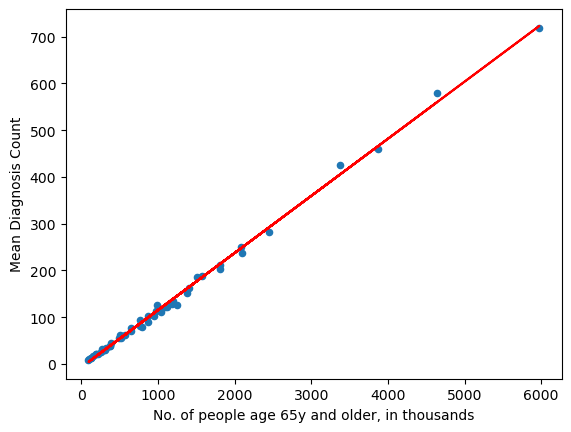

In [49]:
# scatterplot of Diagnosis Count vs Population for states
df_alz_state.plot.scatter(x="No. of people age 65y and older, in thousands", y="Mean Diagnosis Count")
slope, intercept = np.polyfit(df_alz_state['No. of people age 65y and older, in thousands'], df_alz_state['Mean Diagnosis Count'], 1)
best_fit_line = slope * df_alz_state['No. of people age 65y and older, in thousands'] + intercept
plt.plot(df_alz_state['No. of people age 65y and older, in thousands'], best_fit_line, color='red', label='Best Fit Line')
plt.show()

In [50]:
# Coastal states
coastal_states = [
    "Alabama", "Alaska", "California", "Connecticut", "Delaware", "Florida",
    "Georgia", "Hawaii", "Louisiana", "Maine", "Maryland", "Massachusetts",
    "Mississippi", "New Hampshire", "New Jersey", "New York", "North Carolina",
    "Oregon", "Rhode Island", "South Carolina", "Texas", "Virginia", "Washington"
]

# Landlocked states
landlocked_states = [
    "Arizona", "Arkansas", "Colorado", "Idaho", "Illinois", "Indiana", "Iowa",
    "Kansas", "Kentucky", "Michigan", "Minnesota", "Missouri", "Montana", "Nebraska",
    "Nevada", "New Mexico", "North Dakota", "Ohio", "Oklahoma", "Pennsylvania",
    "South Dakota", "Tennessee", "Utah", "Vermont", "West Virginia", "Wisconsin",
    "Wyoming"
]


### 2 sample t Test - Landlocked vs Coastal

In [51]:
df_alz_landlocked = df_alz[df_alz["state"].isin(landlocked_states)]
df_alz_coastal = df_alz[df_alz["state"].isin(coastal_states)]

In [52]:
sample1 = list(df_alz_coastal["Mean Prevelance%"].sample(20))
sample2 = list(df_alz_landlocked["Mean Prevelance%"].sample(20))

In [53]:
mean_1 = sum(sample1)/len(sample1)
std_1 = sum((x - mean_1) ** 2 for x in sample1) / (len(sample1) - 1)
mean_2 = sum(sample2)/len(sample2)
std_2 = sum((x - mean_2) ** 2 for x in sample2) / (len(sample2) - 1)

print(mean_1)
print(std_1)
print(mean_2)
print(std_2)

12.69
4.486210526315789
10.97
0.989578947368421


In [54]:
from scipy.stats import ttest_ind
test_statistic, p_value = ttest_ind(a=sample1, b=sample2, equal_var=True)
print("Test Statistic: " + str(test_statistic))
print("P Value: " + str(p_value))

Test Statistic: 3.287154171190472
P Value: 0.0021841251173163974


In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [56]:
len(df_alz)

3142

In [235]:
west = ["Alaska", "Hawaii", "California", "Oregon", "Washington", "Arizona", "Nevada", "Utah", "Idaho", "Montana", "Wyoming", "Colorado", "New Mexico"]
south = ["Texas", "Oklahoma", "Louisiana", "Arkansas", "Florida", "Mississippi", "Alabama", "Georgia", "South Carolina", "Tennessee", "North Carolina", "Kentucky"]
northeast = ["Virginia", "West Virginia", "Maryland", "Delaware", "Pennsylvania", "New Jersey", "New York", "Connecticut", "Rhode Island", "Massachusetts", "New Hampshire", "Maine", "Vermont"]
midwest = ["Minnesota", "Iowa", "Missouri", "Illinois", "Indiana", "Ohio", "Michigan", "Kansas", "Nebraska", "South Dakota", "North Dakota", "Wisconsin"]
len(midwest) + len(west) + len(south) + len(northeast)

50

In [236]:
df_alz_west = df_alz[df_alz["state"].isin(west)]

In [237]:
df_alz_west_X = df_alz_west[["FIPS"]]

In [238]:
df_alz_west_Y = df_alz_west[["Mean Diagnosis Count"]]

In [239]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
X_train, X_test = train_test_split(df_alz_west_X, train_size=0.8, test_size=0.2, random_state=100)
Y_train, Y_test = train_test_split(df_alz_west_Y, train_size=0.8, test_size=0.2, random_state=100)

In [240]:
X_train.head(10)

,FIPS
264,8037.0
2239,41063.0
228,6083.0
2970,53035.0
3136,56035.0
1749,32005.0
2792,49031.0
2219,41023.0
296,8101.0
584,16067.0


In [241]:

Y_train.head(10)

,Mean Diagnosis Count
264,0.6
2239,0.2
228,8.8
2970,5.0
3136,0.2
1749,1.5
2792,0.0
2219,0.3
296,3.9
584,0.4


In [242]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

X_train_lm = sm.add_constant(X_train)
X_test_lm = sm.add_constant(X_test)
lr = sm.OLS(Y_train, X_train_lm).fit()

print(lr.summary())

Y_pred = lr.predict(X_test_lm)

# Evaluating the model
mse = mean_squared_error(Y_test, Y_pred)  # Mean Squared Error
r2 = r2_score(Y_test, Y_pred)  # R-squared

# Output the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

                             OLS Regression Results                             
Dep. Variable:     Mean Diagnosis Count   R-squared:                       0.019
Model:                              OLS   Adj. R-squared:                  0.017
Method:                   Least Squares   F-statistic:                     7.038
Date:                  Sun, 17 Nov 2024   Prob (F-statistic):            0.00834
Time:                          17:13:15   Log-Likelihood:                -1403.0
No. Observations:                   357   AIC:                             2810.
Df Residuals:                       355   BIC:                             2818.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6140      1.138

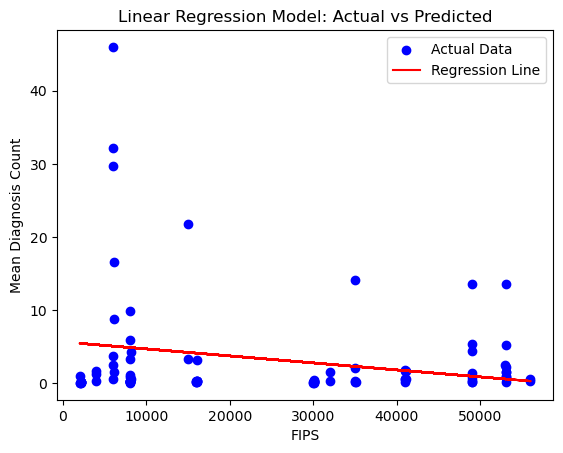

In [243]:
plt.scatter(X_test['FIPS'], Y_test, color='blue', label='Actual Data')

# Plotting the regression line (using the predicted values)
plt.plot(X_test['FIPS'], Y_pred, color='red', label='Regression Line')

# Adding labels and title
plt.xlabel('FIPS')
plt.ylabel('Mean Diagnosis Count')
plt.title('Linear Regression Model: Actual vs Predicted')

# Showing the legend
plt.legend()

# Displaying the plot
plt.show()